In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../data/raw/o.csv")
df["pub_date"] = pd.to_datetime(df["pub_date"])
df.drop(df.columns[:2], inplace=True, axis=1)
df.drop("6", inplace=True, axis=1)
df.set_index("pub_date", inplace=True)
df["difference"] = df["actual"] - df["forecast"]
# df["direction"] = df["5"] - df["1"]
# df["direction"] = df["direction"].apply(lambda x: 1 if x>=0 else 0)
df.head()

,actual,forecast,previous,rolling_std,z-score,1,5,7,difference
pub_date,,,,,,,,,
2008-03-26,0.1,1.7,0.1,3.888785,-0.411440,72.940002,59.943302,0.053213,-1.6
2008-04-02,7.3,2.3,0.1,3.109845,1.607797,75.430000,61.676708,0.028507,5.0
2008-04-09,-3.1,2.3,7.3,3.538222,-1.526190,78.519997,63.490719,0.028987,-5.4
2008-04-16,-2.4,1.8,-3.1,3.801634,-1.104788,80.199997,66.433479,0.045307,-4.2
2008-04-23,2.4,1.5,-2.4,3.771866,0.238609,84.410004,67.658936,0.018278,0.9


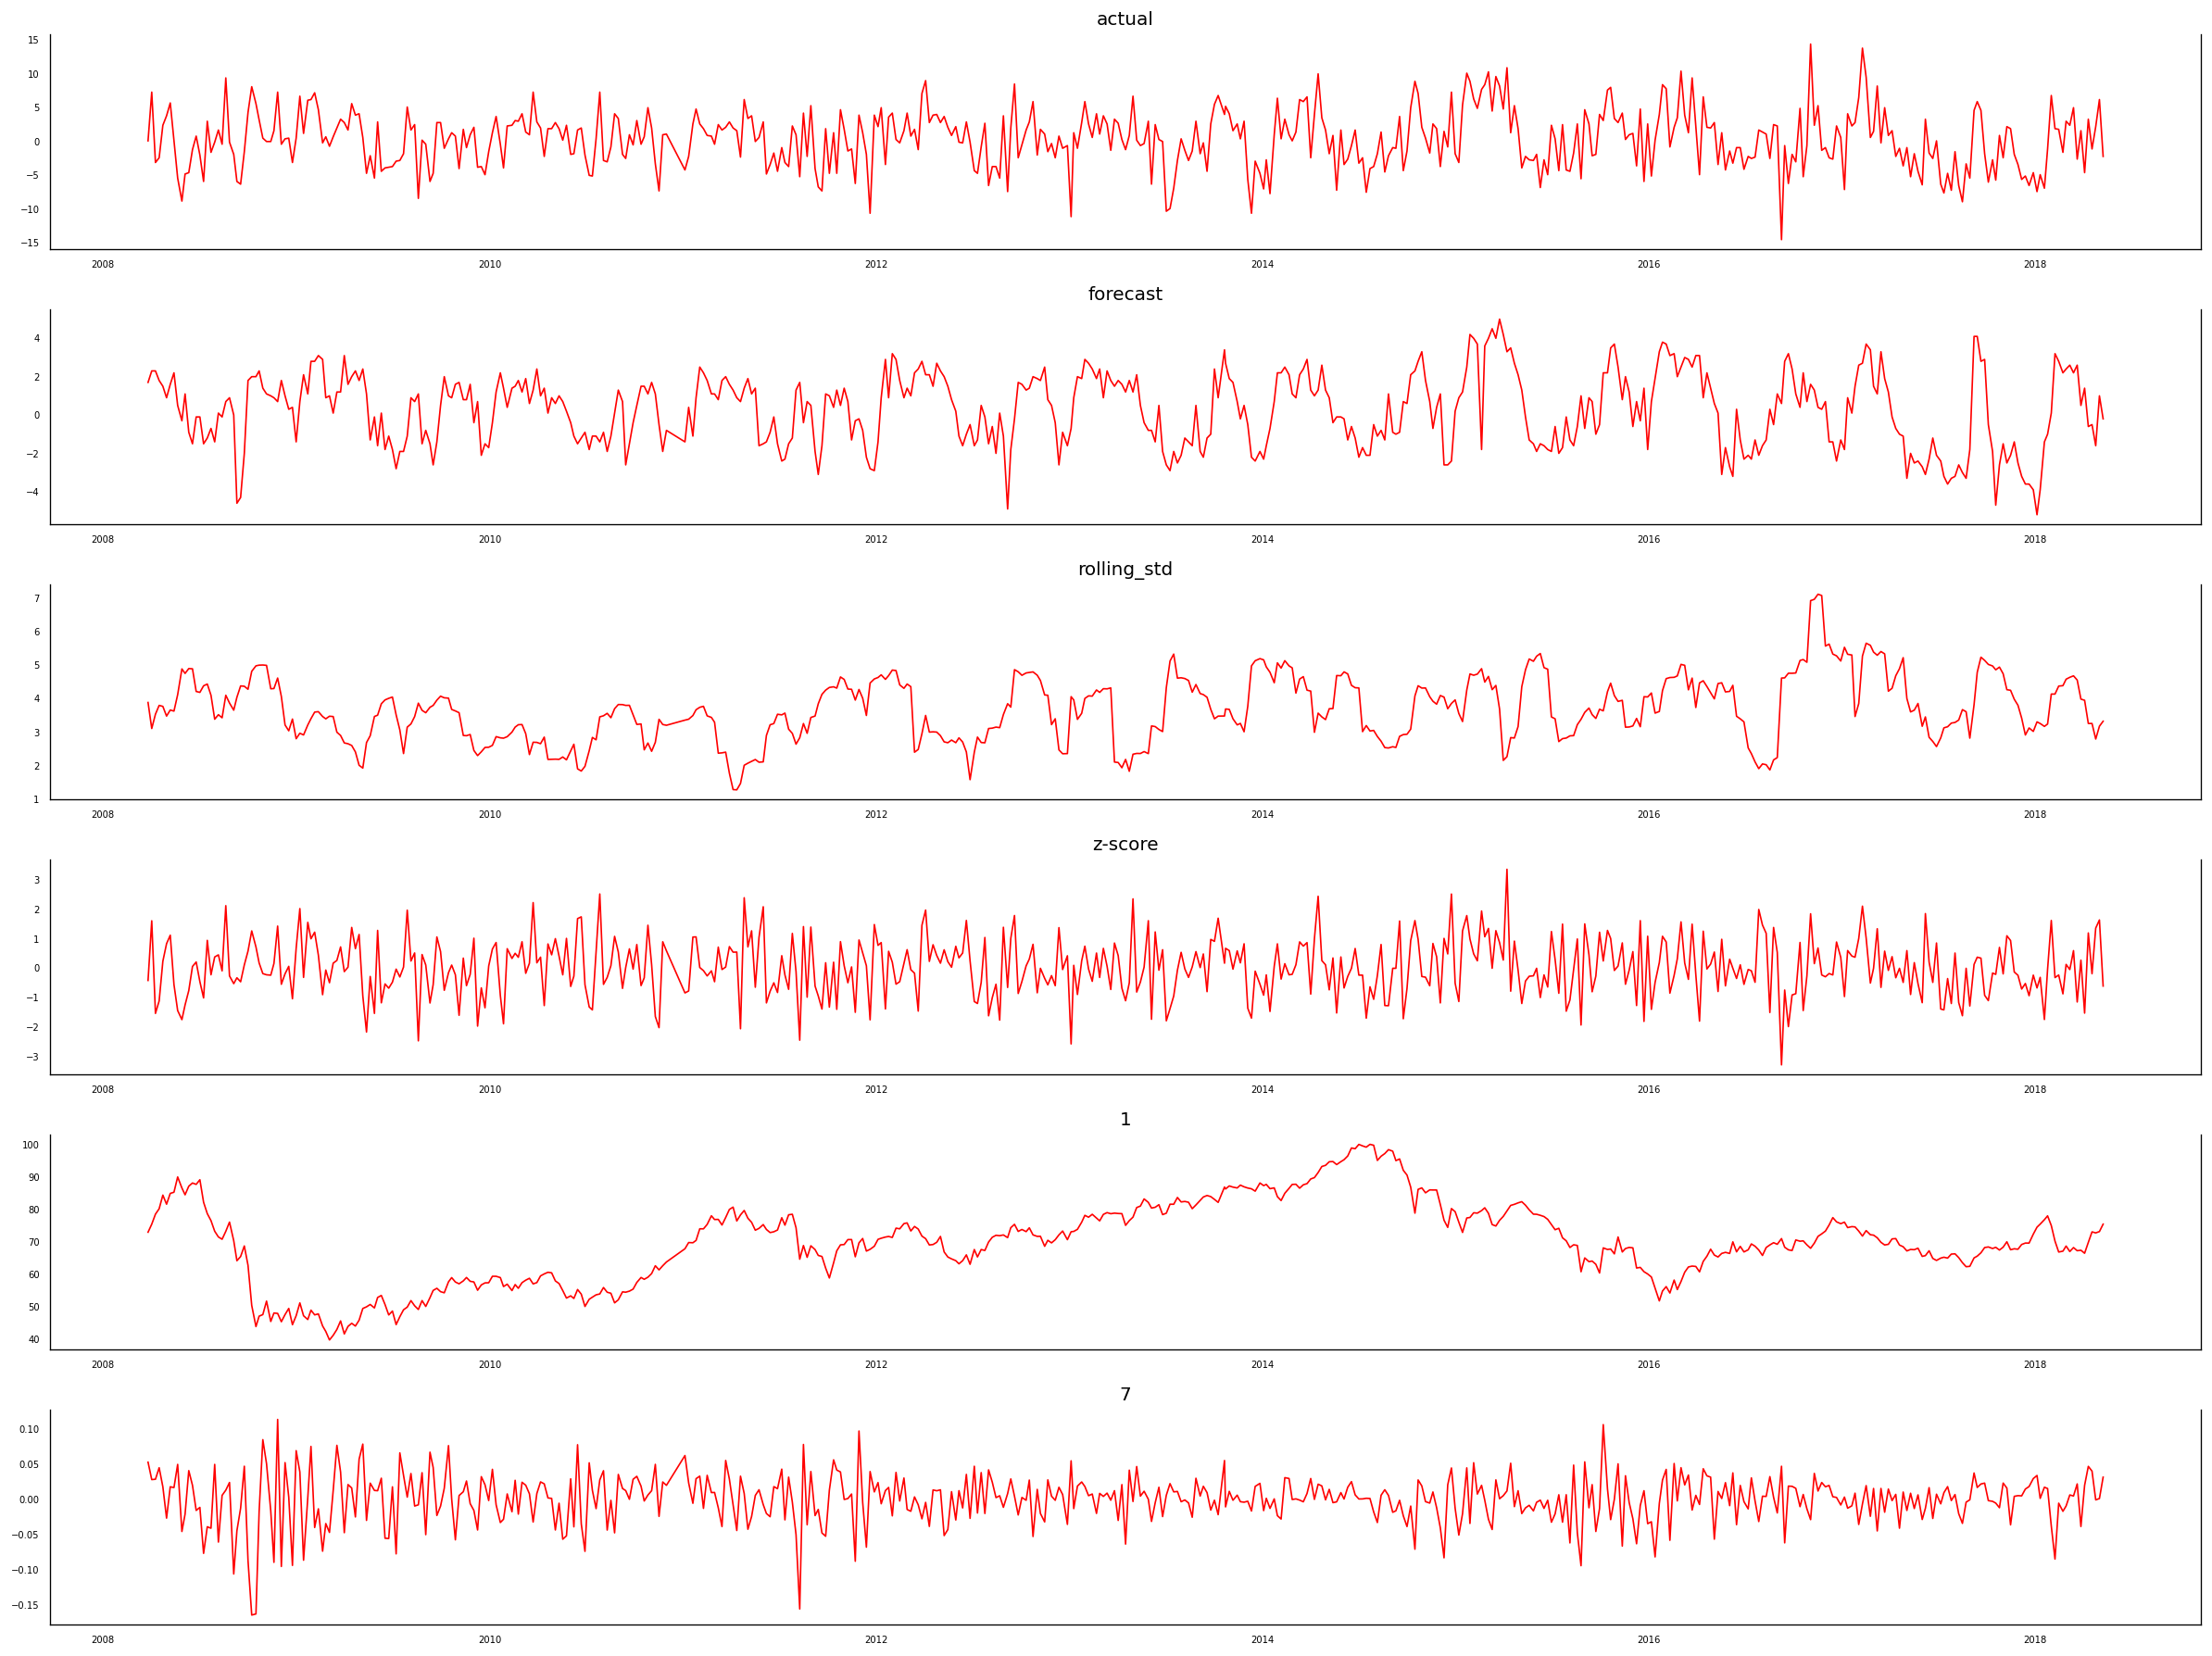

In [4]:
## Plot 

columns = ["actual", "forecast", "rolling_std", "z-score", "1", "7"]
fig, axes = plt.subplots(nrows=6, ncols=1, dpi=120, figsize=(20,15))
for i, ax in enumerate(axes.flatten()):
#     print(columns[i])
    data = df[columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [5]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = columns)

,actual_x,forecast_x,rolling_std_x,z-score_x,1_x,7_x
actual_y,1.0000,0.0000,0.2141,0.0000,0.3259,0.1749
forecast_y,0.0000,1.0000,0.2550,0.0000,0.0607,0.2220
rolling_std_y,0.0191,0.3300,1.0000,0.2521,0.2624,0.1610
z-score_y,0.0021,0.0030,0.0438,1.0000,0.3414,0.1654
1_y,0.3802,0.0097,0.4738,0.2500,1.0000,0.0000
7_y,0.6266,0.0404,0.3960,0.4160,0.0079,1.0000


In [6]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df[columns])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
actual ::  402.72    > 83.9383   =>   True
forecast ::  236.43    > 60.0627   =>   True
rolling_std ::  153.88    > 40.1749   =>   True
z-score ::  80.1      > 24.2761   =>   True
1      ::  34.12     > 12.3212   =>   True
7      ::  0.24      > 4.1296    =>   False


In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [8]:
for col in columns:
    adfuller_test(df[col].values)
    print('\n')

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.99
 No. Lags Chosen       = 4
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6546
 No. Lags Chosen       = 2
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic 

In [9]:
## Lag output by 1
df["7_1"] = df["7"].shift(1).fillna(0)

# separate into features and target
X = df[["actual", "forecast", "rolling_std", "z-score", "1", "7_1"]]
y = df["7"]

# separate into train & test
X_train, X_test = X.iloc[:int(0.8*len(X)),:], X.iloc[int(0.8*len(X)):,:]
y_train, y_test = y[:int(0.8*len(X))], y[int(0.8*len(X)):] 

# persistence model
def baseline_model(row):
    return row["7_1"]

# make predictions
preds = []
for idx, row in X_test.iterrows():
    pred = row["7_1"]
    preds.append(pred)
    
# evaluate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(y_test, preds), "MAE")
print(mean_squared_error(y_test, preds), "MSE")

0.02615459657882351 MAE
0.001140278012478702 MSE


In [10]:
correct = 0
for idx, val in enumerate(preds):
    original = y_test[idx]
    if (original >= 0) and (val >= 0):
        
        correct += 1
    elif (original < 0) and (val < 0):
        correct += 1
    else:
        pass

print("Accuracy", correct/len(y_test))

Accuracy 0.45714285714285713


ACF for actual :


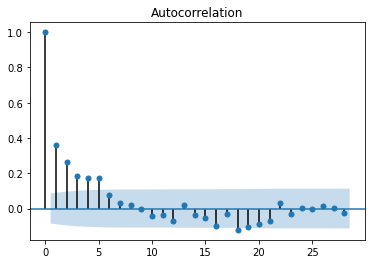

ACF for forecast :


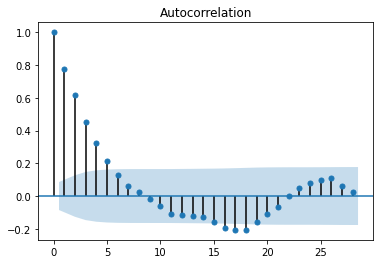

ACF for previous :


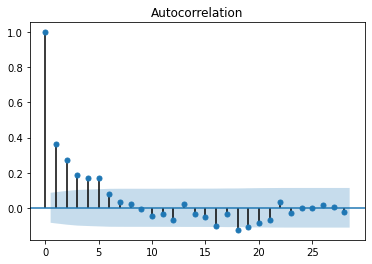

ACF for rolling_std :


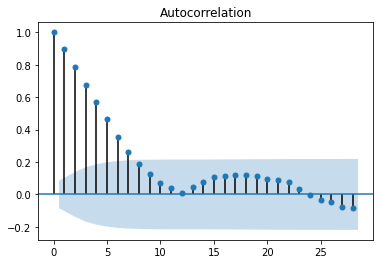

ACF for z-score :


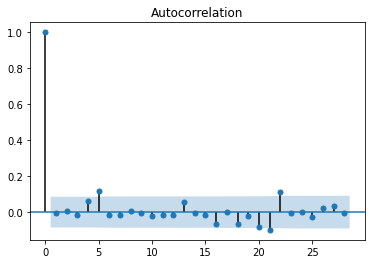

ACF for 1 :


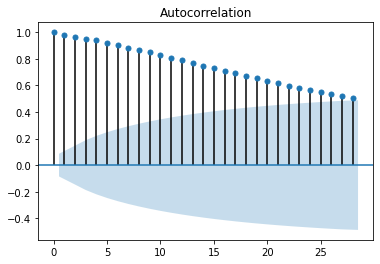

ACF for 5 :


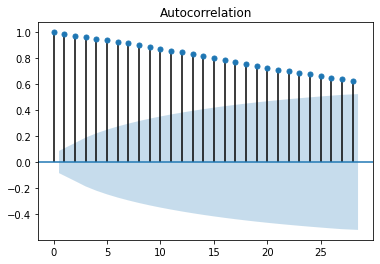

ACF for 7 :


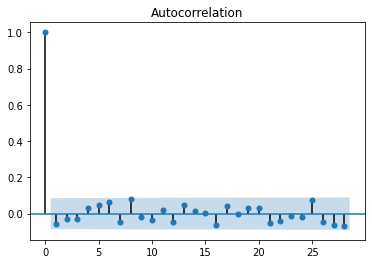

ACF for difference :


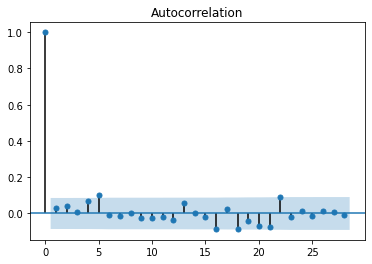

ACF for 7_1 :


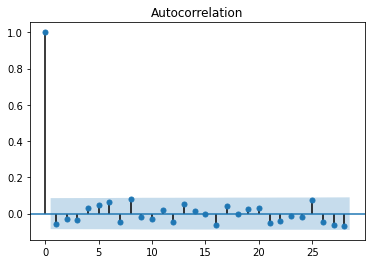

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

for col in df.columns:
    series = df[col]
    print("ACF for", col, ":")
    plot_acf(series)
    plt.show()

In [12]:
df = df[columns]

for col in df.columns:
    lag_col_name = col + "_1"
    df[lag_col_name] = df[col].shift(1).fillna(0)
    
df.head()

,actual,forecast,rolling_std,z-score,1,7,actual_1,forecast_1,rolling_std_1,z-score_1,1_1,7_1
pub_date,,,,,,,,,,,,
2008-03-26,0.1,1.7,3.888785,-0.411440,72.940002,0.053213,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2008-04-02,7.3,2.3,3.109845,1.607797,75.430000,0.028507,0.1,1.7,3.888785,-0.411440,72.940002,0.053213
2008-04-09,-3.1,2.3,3.538222,-1.526190,78.519997,0.028987,7.3,2.3,3.109845,1.607797,75.430000,0.028507
2008-04-16,-2.4,1.8,3.801634,-1.104788,80.199997,0.045307,-3.1,2.3,3.538222,-1.526190,78.519997,0.028987
2008-04-23,2.4,1.5,3.771866,0.238609,84.410004,0.018278,-2.4,1.8,3.801634,-1.104788,80.199997,0.045307


In [13]:
feature_cols = ["actual", "actual_1", "forecast", "forecast_1", "rolling_std", "rolling_std_1", "z-score", "z-score_1",
               "1", "1_1", "7_1"]

# split
X, y = df[feature_cols], df["7"]

# train-test split
X_train, X_test = X.iloc[:int(0.8*len(X)),:], X.iloc[int(0.8*len(X)):,:]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

In [14]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(420, 11) (105, 11)
(420,) (105,)


In [15]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [16]:
for col in X_train.columns:
    series = X_train[col]
    ranges = outlier_treatment(series)
    print("Percentage of values as outliers for", col, "are: ")
    outliers = (series < ranges[0]) | (series > ranges[1])
    print(sum(outliers), len(series))
#     print(len(series) - sum(new_series))

Percentage of values as outliers for actual are: 
6 420
Percentage of values as outliers for actual_1 are: 
6 420
Percentage of values as outliers for forecast are: 
0 420
Percentage of values as outliers for forecast_1 are: 
0 420
Percentage of values as outliers for rolling_std are: 
0 420
Percentage of values as outliers for rolling_std_1 are: 
1 420
Percentage of values as outliers for z-score are: 
2 420
Percentage of values as outliers for z-score_1 are: 
2 420
Percentage of values as outliers for 1 are: 
0 420
Percentage of values as outliers for 1_1 are: 
1 420
Percentage of values as outliers for 7_1 are: 
16 420


In [17]:
from sklearn.preprocessing import RobustScaler

interest_cols = ["actual", "actual_1", "rolling_std_1", "z-score", "z-score_1", "1_1", "7_1"]
for col in interest_cols:
    scaler = RobustScaler()
    X_train.loc[:,col] = scaler.fit_transform(X_train[[col]])
    X_test.loc[:,col] = scaler.transform(X_test[[col]])

In [18]:
X_train.corr()

,actual,actual_1,forecast,forecast_1,rolling_std,rolling_std_1,z-score,z-score_1,1,1_1,7_1
actual,1.000000,0.356041,0.542094,0.447597,-0.037438,0.015697,0.866894,0.164813,-0.061514,-0.077974,0.037353
actual_1,0.356041,1.000000,0.663564,0.542222,-0.038190,-0.035925,0.056964,0.866801,-0.065702,-0.057622,0.061552
forecast,0.542094,0.663564,1.000000,0.747044,0.025912,0.050951,0.105704,0.373661,-0.062945,-0.072274,0.061855
forecast_1,0.447597,0.542222,0.747044,1.000000,-0.001005,0.027896,0.134265,0.105670,-0.057097,-0.057893,0.001670
rolling_std,-0.037438,-0.038190,0.025912,-0.001005,1.000000,0.867849,-0.078837,-0.064252,0.197902,0.184946,-0.011808
rolling_std_1,0.015697,-0.035925,0.050951,0.027896,0.867849,1.000000,-0.021199,-0.077362,0.195086,0.236326,0.008157
z-score,0.866894,0.056964,0.105704,0.134265,-0.078837,-0.021199,1.000000,-0.015888,-0.030162,-0.046334,0.024752
z-score_1,0.164813,0.866801,0.373661,0.105670,-0.064252,-0.077362,-0.015888,1.000000,-0.039609,-0.028265,0.074173
1,-0.061514,-0.065702,-0.062945,-0.057097,0.197902,0.195086,-0.030162,-0.039609,1.000000,0.952746,0.076655
1_1,-0.077974,-0.057622,-0.072274,-0.057893,0.184946,0.236326,-0.046334,-0.028265,0.952746,1.000000,0.060268


In [19]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_model_pred = linear_model.predict(X_test)
print("MSE is:", mean_squared_error(linear_model_pred, y_test))
print("MAE is:", mean_absolute_error(linear_model_pred, y_test))

MSE is: 0.0004151186528772177
MAE is: 0.015860364281817592


Column: actual


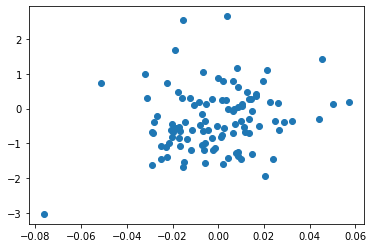

Column: actual_1


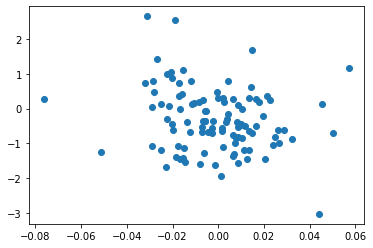

Column: forecast


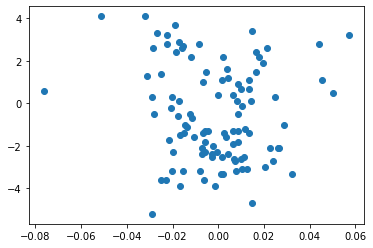

Column: forecast_1


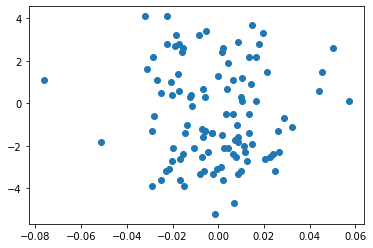

Column: rolling_std


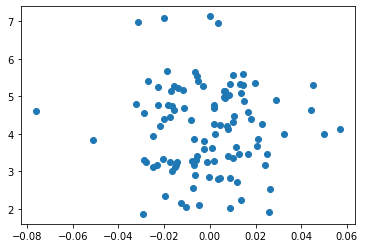

Column: rolling_std_1


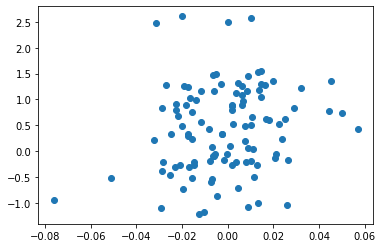

Column: z-score


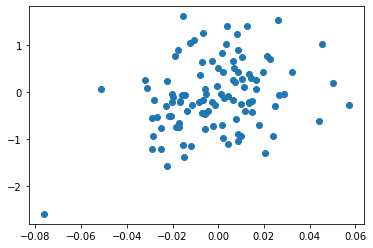

Column: z-score_1


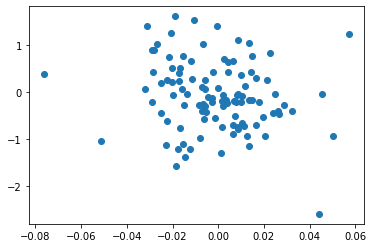

Column: 1


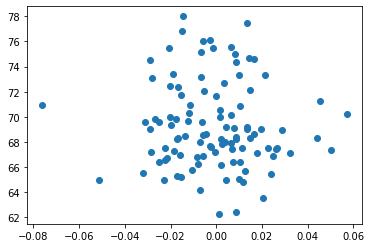

Column: 1_1


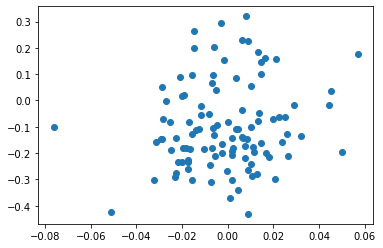

Column: 7_1


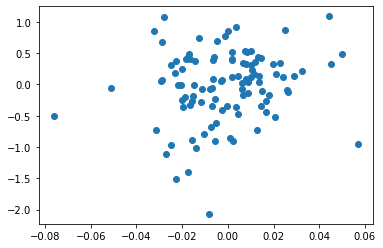

In [20]:
## 1. Residual vs Predicting Variable Plots

residuals = linear_model_pred - y_test.values

for col in X_test.columns:
    print("Column:", col)
    plt.scatter(residuals, X_test[col])
    plt.show()

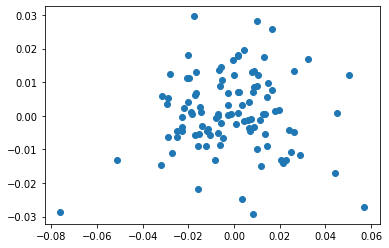

In [21]:
## 2. Residual vs Fitted Values

plt.scatter(residuals, linear_model_pred)
plt.show()

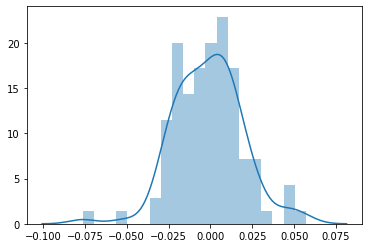

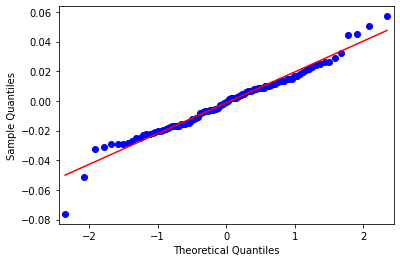

In [22]:
### 3. Histogram & Q-Q plot

import statsmodels.api as sm

# histogram
sns.distplot(residuals, bins=20)
plt.show()

# Q-Q plot
sm.qqplot(residuals, line="r")
plt.show()

In [23]:
## Feature importance
# get importance
importance = linear_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00252
Feature: 1, Score: -0.00768
Feature: 2, Score: -0.00207
Feature: 3, Score: 0.00287
Feature: 4, Score: -0.01408
Feature: 5, Score: 0.02141
Feature: 6, Score: -0.00092
Feature: 7, Score: 0.00713
Feature: 8, Score: 0.00516
Feature: 9, Score: -0.10639
Feature: 10, Score: -0.00359


In [24]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor(random_state=42, criterion="mae", max_depth=5, max_features="log2")
decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)
print("MAE", mean_absolute_error(decision_tree_pred, y_test))
print("MSE", mean_squared_error(decision_tree_pred, y_test))

MAE 0.0180434837476664
MSE 0.0005671143495428507


In [25]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(random_state=42, n_estimators=200, criterion="mae", max_features="log2")
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)
print("MAE", mean_absolute_error(random_forest_pred, y_test))
print("MSE", mean_squared_error(random_forest_pred, y_test))

MAE 0.017689744890118084
MSE 0.0005337293911527317


In [26]:
pd.DataFrame(random_forest.feature_importances_, index = X_train.columns,
                    columns=['importance']).sort_values('importance', ascending=False)

,importance
1,0.126442
7_1,0.123358
1_1,0.115915
z-score,0.090585
z-score_1,0.085072
actual_1,0.080684
rolling_std_1,0.078933
rolling_std,0.077285
forecast_1,0.075184
forecast,0.073353


In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boost = GradientBoostingRegressor(criterion="mae", random_state=42)
gradient_boost.fit(X_train, y_train)
gradient_boost_pred = gradient_boost.predict(X_test)
print("MAE", mean_absolute_error(gradient_boost_pred, y_test))
print("MSE", mean_squared_error(gradient_boost_pred, y_test))

MAE 0.01637617044813146
MSE 0.0004854331559433783


In [30]:
correct = 0
for idx, val in enumerate(gradient_boost_pred):
    original = y_test[idx]
    if (original >= 0) and (val >= 0):
        
        correct += 1
    elif (original < 0) and (val < 0):
        correct += 1
    else:
        pass

print("Accuracy", correct/len(y_test))

Accuracy 0.6857142857142857


In [ ]:
X_train